# Import all the necessary libraries

In [ ]:
import torch
import numpy as np
from transformers import PatchTSTForPretraining
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from torch.utils.data import Dataset, DataLoader

## Data preprocessing
 - The earth FM expects 48 timesteps per pixel. Make sure to aggregate appropriately


In [5]:
# This is a dummy dataset
# N.B. This df is for illustration only and should only be used to get an understanding of the problem. This data is completely fictious.
train_data = pd.read_csv('dummy_satellite_data.csv')
train_data.head()


,unique_id,time,x,y,crop_type,red,nir,swir16,swir22,blue,green,rededge1,rededge2,rededge3,nir08
0,PIXEL_0001,2018-01-01 00:00:00.000,274312.192156,763161.256666,cocoa,0.185399,0.470621,0.423230,0.248294,0.240145,0.220656,0.322180,0.482940,0.449330,0.477607
1,PIXEL_0001,2018-01-09 00:00:00.000,274312.192156,763161.256666,cocoa,0.220038,0.532922,0.309975,0.323104,0.266787,0.294504,0.525136,0.502824,0.423608,0.422886
2,PIXEL_0001,2018-01-17 00:00:00.000,274312.192156,763161.256666,cocoa,0.250492,0.630413,0.290035,0.331941,0.338385,0.348162,0.350808,0.461883,0.514735,0.578810
3,PIXEL_0001,2018-01-25 00:00:00.000,274312.192156,763161.256666,cocoa,0.259566,0.487199,0.381297,0.322500,0.292686,0.420341,0.401141,0.504158,0.480010,0.569881
4,PIXEL_0001,2018-02-02 00:00:00.000,274312.192156,763161.256666,cocoa,0.300939,0.670061,0.448583,0.364932,0.350569,0.289149,0.406982,0.506831,0.534893,0.541207


In [6]:
test_data = pd.read_csv('test.csv')
test_data.head()

,unique_id,time,x,y,red,nir,swir16,swir22,blue,green,rededge1,rededge2,rededge3,nir08
0,ID_01FHV4,2018-01-03 10:59:22.851,-296455.0,846395.0,0.2920,0.3686,0.4173,0.3869,0.2488,0.2708,0.3211,0.3555,0.3752,0.3862
1,ID_01FHV4,2018-01-03 10:59:22.851,-296455.0,846395.0,0.2920,0.3686,0.4173,0.3869,0.2488,0.2708,0.3211,0.3555,0.3752,0.3862
2,ID_01FHV4,2018-02-12 10:59:25.232,-296455.0,846395.0,0.3510,0.3426,0.4817,0.4577,0.2538,0.2914,0.3684,0.3484,0.3588,0.3628
3,ID_01FHV4,2018-02-12 10:59:25.232,-296455.0,846395.0,0.3510,0.3426,0.4817,0.4577,0.2538,0.2914,0.3684,0.3484,0.3588,0.3628
4,ID_01FHV4,2018-03-14 10:59:24.436,-296455.0,846395.0,0.5312,0.6296,0.6643,0.5882,0.5244,0.5308,0.6016,0.6217,0.6401,0.6404


In [7]:
train_data['crop_type'].value_counts()

crop_type
cocoa     4647
rubber    4645
oil       4642
Name: count, dtype: int64

In [8]:
timesteps_per_pixel = train_data.groupby('unique_id').size()  #count the timesteps per pixel since model expects 48 timesteps per pixel

print("Total timesteps per pixel:", len(timesteps_per_pixel))
print("Minimum timesteps per pixel:", timesteps_per_pixel.min())
print("Maximum timesteps per pixel:", timesteps_per_pixel.max())
print("Average timesteps per pixel:", timesteps_per_pixel.mean())

Total timesteps per pixel: 300
Minimum timesteps per pixel: 30
Maximum timesteps per pixel: 48
Average timesteps per pixel: 46.446666666666665


In [9]:
test_pixel = test_data.groupby('unique_id').size()  #count the timesteps per pixel since model expects 48 timesteps per pixel

print("Total timesteps per pixel:", len(test_pixel))
print("Minimum timesteps per pixel:", test_pixel.min())
print("Maximum timesteps per pixel:", test_pixel.max())
print("Average timesteps per pixel:", test_pixel.mean())

Total timesteps per pixel: 10523
Minimum timesteps per pixel: 74
Maximum timesteps per pixel: 740
Average timesteps per pixel: 114.33155944122399


In [10]:
bands = ['red', 'nir', 'swir16', 'swir22', 'blue', 'green','rededge1', 'rededge2', 'rededge3', 'nir08']  # The spectral bands in the dataset

In [11]:
# You can have different ways to aggregate data to the required timesteps
# Below we have use interpolation, but remember it might introduce noise

from scipy.interpolate import CubicSpline
import numpy as np
import pandas as pd

def preprocess_with_interpolation(df, bands):
    all_results = []
    has_crop_type = 'crop_type' in df.columns

    for pixel_id, group in df.groupby('unique_id'):
        group = group.sort_values('time').reset_index(drop=True)

        if len(group) == 48:
            keep_cols = ['unique_id', 'x', 'y'] + bands
            if has_crop_type:
                keep_cols.insert(1, 'crop_type')

            clean_group = group[keep_cols].copy()
            clean_group['timestep'] = range(48)
            all_results.append(clean_group)
        else:
            new_rows = []
            interpolated_bands = {}
            old_times = np.arange(len(group))
            new_times = np.linspace(0, len(group) - 1, 48)

            for band in bands:
                spline = CubicSpline(old_times, group[band].values)
                interpolated_bands[band] = spline(new_times)

            for i in range(48):
                new_row = {
                    'unique_id': pixel_id,
                    'timestep': i,
                    'x': group['x'].iloc[0],
                    'y': group['y'].iloc[0]
                }
                if has_crop_type:
                    new_row['crop_type'] = group['crop_type'].iloc[0]

                for band in bands:
                    new_row[band] = interpolated_bands[band][i]

                new_rows.append(new_row)

            all_results.append(pd.DataFrame(new_rows))

    final_df = pd.concat(all_results, ignore_index=True)
    return final_df


In [12]:
preprocessed_train_data = preprocess_with_interpolation(train_data, bands)
preprocessed_test_data = preprocess_with_interpolation(test_data, bands)

In [13]:
train_pixel = preprocessed_train_data.groupby('unique_id').size()  #count the timesteps per pixel since model expects 48 timesteps per pixel

print("Minimum timesteps per pixel:", train_pixel.min())
print("Maximum timesteps per pixel:", train_pixel.max())


Minimum timesteps per pixel: 48
Maximum timesteps per pixel: 48


# MODELLING
- The earth FM was pretrained on a vast amount of Sentinel 2 unlabeled timeseries data, built on [PATCHTST](https://huggingface.co/docs/transformers/en/model_doc/patchtst#transformers.PatchTSTForPretraining) architecture.
- The pretrained model can be used in different ways: finetuning though supervised classification, as a feature extractor etc.

Download the models on hugging face
 - [600K](https://huggingface.co/AminiTech/FM-600K)
 - [18M](https://huggingface.co/AminiTech/fm-v2-28M)

The model expects a dataset and its mask as input

In [15]:
# use the model as a feature extractor for RF model
def extract_patch_embeddings(model, past_values):
    past_observed_mask = ~torch.isnan(past_values)

    with torch.no_grad():
        model_output = model.model(
            past_values=past_values,
            past_observed_mask=past_observed_mask,
            return_dict=True
        )
        embeddings = model_output.last_hidden_state
        all_patches = embeddings[:, :, 1:, :]
        final_embeddings = all_patches.mean(dim=(1, 2))  # average of all patch level embeddings
        return final_embeddings


In [16]:
hf_token = os.getenv('HUGGINGFACE_HUB_TOKEN')
MODEL_PATH = "AminiTech/fm-v2-28M"


In [25]:
class CropDataset(Dataset):
    def __init__(self, sequences, labels, unique_ids):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = labels
        self.unique_ids = unique_ids

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item = {
            'sequence': self.sequences[idx],
            'unique_id': self.unique_ids[idx]
        }
        if self.labels is not None:
            item['label'] = self.labels[idx]
        return item


def prepare_sequences_from_df(df):
    sequences = []
    labels = []
    unique_ids = []
    has_labels = 'crop_type' in df.columns

    for unique_id, group in df.groupby('unique_id'):
        spectral_data = group[bands].values
        sequences.append(spectral_data)
        unique_ids.append(unique_id)

        if has_labels:
            labels.append(group['crop_type'].iloc[0])

    sequences = np.array(sequences)

    print(f"Prepared {len(sequences)} sequences")

    if has_labels:
        print(f"Crop distribution:")
        unique, counts = np.unique(labels, return_counts=True)
        for crop, count in zip(unique, counts):
            print(f"  {crop}: {count}")
    else:
        labels = None

    return sequences, labels, unique_ids

def extract_embeddings_from_dataloader(model, dataloader):
    model.eval()
    all_embeddings = []
    all_ids = []

    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in dataloader:
            sequences = batch['sequence'].to(device)
            embeddings = extract_patch_embeddings(model, sequences)

            all_embeddings.append(embeddings.cpu())  # Move to CPU before collecting
            all_ids.extend(batch['unique_id'])

    return torch.cat(all_embeddings, dim=0), all_ids

In [26]:
train_seq, train_labels, train_ids = prepare_sequences_from_df(preprocessed_train_data)
train_dataset = CropDataset(train_seq, train_labels, train_ids)


Prepared 300 sequences
Crop distribution:
  cocoa: 100
  oil: 100
  rubber: 100


In [27]:
print("Train sequences shape:", train_seq.shape)


Train sequences shape: (300, 48, 10)


In [28]:
test_seq, test_labels, test_ids = prepare_sequences_from_df(preprocessed_test_data)
test_dataset = CropDataset(test_seq, test_labels, test_ids)

Prepared 10523 sequences


In [29]:
print("Test sequences shape:", test_seq.shape)

Test sequences shape: (10523, 48, 10)


In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [31]:
# Load model
model = PatchTSTForPretraining.from_pretrained(MODEL_PATH, token=hf_token)
model.eval()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/75.8M [00:00<?, ?B/s]

PatchTSTForPretraining(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTMeanScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): PatchTSTMasking()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=12, out_features=512, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-5): 6 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
 

In [33]:
train_embeddings, train_ids = extract_embeddings_from_dataloader(model, train_loader)
test_embeddings, test_ids = extract_embeddings_from_dataloader(model, test_loader)

AttributeError: 'list' object has no attribute 'shape'

In [37]:
print(len(train_ids))
print(train_ids)

300
['PIXEL_0095', 'PIXEL_0052', 'PIXEL_0149', 'PIXEL_0238', 'PIXEL_0234', 'PIXEL_0198', 'PIXEL_0279', 'PIXEL_0195', 'PIXEL_0053', 'PIXEL_0084', 'PIXEL_0165', 'PIXEL_0064', 'PIXEL_0089', 'PIXEL_0250', 'PIXEL_0241', 'PIXEL_0242', 'PIXEL_0071', 'PIXEL_0077', 'PIXEL_0221', 'PIXEL_0055', 'PIXEL_0128', 'PIXEL_0249', 'PIXEL_0001', 'PIXEL_0109', 'PIXEL_0156', 'PIXEL_0273', 'PIXEL_0056', 'PIXEL_0010', 'PIXEL_0113', 'PIXEL_0036', 'PIXEL_0094', 'PIXEL_0100', 'PIXEL_0060', 'PIXEL_0158', 'PIXEL_0066', 'PIXEL_0102', 'PIXEL_0137', 'PIXEL_0180', 'PIXEL_0041', 'PIXEL_0172', 'PIXEL_0201', 'PIXEL_0019', 'PIXEL_0206', 'PIXEL_0247', 'PIXEL_0007', 'PIXEL_0157', 'PIXEL_0146', 'PIXEL_0086', 'PIXEL_0159', 'PIXEL_0148', 'PIXEL_0154', 'PIXEL_0012', 'PIXEL_0029', 'PIXEL_0276', 'PIXEL_0130', 'PIXEL_0002', 'PIXEL_0290', 'PIXEL_0213', 'PIXEL_0143', 'PIXEL_0123', 'PIXEL_0280', 'PIXEL_0190', 'PIXEL_0028', 'PIXEL_0152', 'PIXEL_0058', 'PIXEL_0031', 'PIXEL_0300', 'PIXEL_0133', 'PIXEL_0141', 'PIXEL_0147', 'PIXEL_0267', '

In [39]:
print(f"Embeddings shape: Train {train_embeddings.shape}, Test {test_embeddings.shape}")

Embeddings shape: Train torch.Size([300, 512]), Test torch.Size([10523, 512])


In [45]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
print(train_labels_encoded)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [43]:
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=100)
rf_model.fit(train_embeddings.numpy(), train_labels_encoded)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [47]:
# Evaluate
test_predictions_encoded = rf_model.predict(test_embeddings.numpy())


In [49]:
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

submission = pd.DataFrame({
    'ID': test_ids,
    'Target': test_predictions
})
submission.head()
# submission.to_csv("submission.csv", index=False)

,ID,Target
0,ID_KKA87X,oil
1,ID_98S22Z,oil
2,ID_LE497V,cocoa
3,ID_VPN6ZF,cocoa
4,ID_GDKAHR,cocoa


In [5]:
import ee
ee.Initialize(project='gradient-growers')


In [8]:
%pip install geopandas


# file_path = 'your_file.geojson' # Replace with the actual path to your GeoJSON file

# try:
#     gdf = geopandas.read_file(file_path)
#     print("GeoDataFrame loaded successfully:")
#     print(gdf.head()) # Display the first few rows of the GeoDataFrame
#     print(gdf.crs) # Print the Coordinate Reference System
# except Exception as e:
#     print(f"Error loading GeoJSON with geopandas: {e}")

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.11.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (5.3 kB)
  Using cached pyproj-3.7.1.tar.gz (226 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 7.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:00 MB/s eta 0:00:010:01
  Created wheel for pyproj: filename=pyproj-3.7.1-cp312-cp312-macosx_11_0_arm64.whl size=508187 sha256=c26364cf3badd75a86760354fea08eda868299b3db59bca4e4b686530515d6f0
  Stored in directory: /Users/jennifer/Library/Caches/pip/wheels/c4/72/c2/294be60784c762c3e785a7e2519c0ec43866c13ec752fb3a09
Successfully built pyproj
Note: you may need to restart the kernel to use updated packages.


In [1]:
import geopandas

In [7]:
longitude = 115.794902228198879
latitude = -1.629352395440254

point = ee.Geometry.Point(longitude, latitude)
start_date = '2024-01-01'
end_date = '2024-01-31'

# Example: Accessing Sentinel-2 Surface Reflectance data
collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(point) \
    .filterDate(start_date, end_date) \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .first() # Get the least cloudy image

if collection:
    # Select specific bands (e.g., B4=Red, B3=Green, B2=Blue, B8=NIR for Sentinel-2)
    # Apply scaling factors if necessary (often provided in dataset metadata)
    # For Sentinel-2 SR, reflectance values are 10000 * actual reflectance
    bands_of_interest = ['B2', 'B3', 'B4', 'B8']
    image_at_point = collection.select(bands_of_interest).sample(point, scale=10).first()

    # Get the band values at the point
    data = image_at_point.getInfo()
    print(f"Band data at ({latitude}, {longitude}):")
    for band in bands_of_interest:
        if band in data['properties']:
            value = data['properties'][band]
            print(f"{band}: {value / 10000.0}") # Scale back to actual reflectance
else:
    print("No image found for the specified location and time range.")


Band data at (-1.629352395440254, 115.79490222819888):
B2: 0.2171
B3: 0.2033
B4: 0.1889
B8: 0.3145


CIV - Coordinate Reference System (CRS): EPSG:4326
GHA - Coordinate Reference System (CRS): EPSG:4326


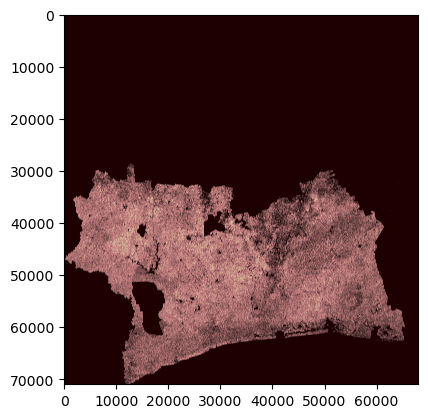

In [15]:
# collecting data from cocoa .tif
import rasterio
from matplotlib import pyplot

CIV_cocao = 'data/Detected_Cocoa_Farms/CIVKakao.tif'
GHA_cocao = 'data/Detected_Cocoa_Farms/GHAKakao.tif'
try:
        with rasterio.open(CIV_cocao) as src:
                band_data = src.read(1)
                print(f'CIV - Coordinate Reference System (CRS): {src.crs}')
                pyplot.imshow(band_data, cmap='pink')
                pyplot.show()
        with rasterio.open(GHA_cocao) as src:
                band_data = src.read(1)
                print(f'GHA - Coordinate Reference System (CRS): {src.crs}')
except rasterio.errors.RasterioIOError as e:
        print(f'Error opening or reading GeoTIFF file: {e}')
except Exception as e:
        print(f'An unexpected error occurred: {e}')

In [1]:
import rasterio
import pandas as pd
import numpy as np

CIV_cocao = 'data/Detected_Cocoa_Farms/CIVKakao.tif'
try:
        with rasterio.open(CIV_cocao) as src:
                band_data = src.read(1)
                print(f'CIV - Coordinate Reference System (CRS): {src.crs}')
                rows, cols = np.nonzero(band_data)
                lons, lats = rasterio.transform.xy(src.transform, rows, cols)
                df = pd.DataFrame({'Longitude': lons, 'Latitude': lats})
                print(df.head())
                df.to_csv('CIVKokao_coordinates.csv', index=False)
except rasterio.errors.RasterioIOError as e:
        print(f'Error opening or reading GeoTIFF file: {e}')
except Exception as e:
        print(f'An unexpected error occurred: {e}')

CIV - Coordinate Reference System (CRS): EPSG:4326
   Longitude  Latitude
0  -2.588001  8.780089
1  -2.588001  8.779999
2  -2.587642  8.779370
3  -2.553147  8.565391
4  -2.553057  8.564762


KeyboardInterrupt: 

In [ ]:
import rasterio
import pandas as pd
import numpy as np

GHA_cocao = 'data/Detected_Cocoa_Farms/GHAKakao.tif'
try:
        with rasterio.open(GHA_cocao) as src:
                band_data = src.read(1)
                print(f'GHA - Coordinate Reference System (CRS): {src.crs}')
                rows, cols = np.nonzero(band_data)
                lons, lats = rasterio.transform.xy(src.transform, rows, cols)
                df = pd.DataFrame({'Longitude': lons, 'Latitude': lats})
                print(df.head())
                df.to_csv('GHAKokao_coordinates.csv', index=False)
except rasterio.errors.RasterioIOError as e:
        print(f'Error opening or reading GeoTIFF file: {e}')
except Exception as e:
        print(f'An unexpected error occurred: {e}')